# This notebook provides a number of examples for how Vivarium can combine SBML models using the Bioscrape Simulator

This notebook described how to use Vivarium-Bioscrape to encapsulate Chemical Reaction Network (CRN) models as Vivarium Processes. This allows for CRN models to be run in parallel (including hybrid stochastic/deterministic simulation), coupled with other modeling modalities (such as physics or flux balance).

__Overview:__ 
1. Systems Biology Markup langauge ([SBML](http://sbml.org/Main_Page)) is a file format to represent Chemical Reaction Network Models. The SBML files used in this notebook are generated via [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler) in the Example Models notebook.
2. The SBML simulator [Bioscrape](https://github.com/biocircuits/bioscrape) has been wrapped in a Vivarium Process, aptly named Bioscrape.
3. Multiple Bioscrape Processes are connected together by creating a BioscrapeConnector which contains lists of models and the connections between them.
4. Models are connected via an arbitrary translation function stored in the OneWayMap object.
5. The BioscrapeConnector can then be simulated. _Warning: Simulation stability may depend strongly on the global coupling time._

Choosing the correct map between CRN models will, in general, be dependent on the model and desired behavior. This problem can be succintly stated: if speciex $X$ in CRN 1 changes by $\Delta_X$, how should the species in CRN 2 change? The OneWayMap class allows for complete user control over how CRN models communicate by encapsulating an arbitrary python function. A number of common examples of OneWayMaps are given in this notebook including: renaming species, mapping one species to many species and many species to one species, mapping increases and decreases differently, dynamic maps which depend upon the current state, and stochastic to deterministic maps.

In [1]:
#Imports
from vivarium_bioscrape.processes.bioscrape import Bioscrape
from vivarium_bioscrape.composites.bioscrape_connector import BioscrapeConnector
from vivarium.core.composition import simulate_compartment_in_experiment
import pylab as plt

# Example 1: one_to_one_mapping

In this example, two species in model 1 will each be linked to a single species in model 4 (two one-to-one mappings)

__Model 1 CRN:__
* $dna\_G \to dna_G + rna\_T$

* $rna\_T \to rna\_T + protein\_X$

__Model 4 CRN:__

* $rna\_RNA \to \emptyset$

* $protein\_Protein \to \emptyset$

Each oneway mapping connects two lists of species such that 
    
    species1[i] = species2[i]

__Mapping 1 $\implies$ 4:__ 

* $rna\_T \implies rna\_RNA$

* $protein\_X \implies protein\_Protein$

__Mapping 4 $\implies$ 1:__ 

* $rna\_RNA \implies rna\_T$

* $protein\_Protein \implies protein\_X$

{'txtl': <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x0000018CA2841248>, 'dilution': <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x0000018CA2841288>}
{'txtl_dilution_connector': <vivarium_bioscrape.processes.one_way_map.OneWayMap object at 0x0000018CA284C0C8>, 'dilution_txtl_connector': <vivarium_bioscrape.processes.one_way_map.OneWayMap object at 0x0000018CA284C4C8>}

Experiment ID: e7df75d8-22f3-11eb-8753-6c2b5976b3a5
Created: 11/09/2020 at 17:27:32


Progress:|██████████████████████████████████████████████████| 0.0/500.0 simulated seconds remaining    
Completed in 0.231100 seconds


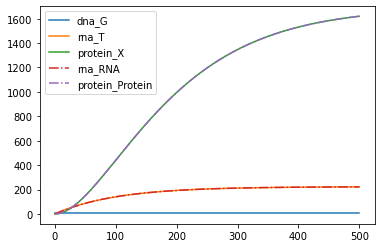

In [2]:
from vivarium_bioscrape.library.mappings import one_to_one_map

#Create Bioscrape Processes
#Model 1: is a simple transcription translation model
bsp1 = Bioscrape(parameters = {
    'sbml_file':'model1.xml'
    })

#Model 4 adds degredation by dilution to proteins and RNAs
bsp2 = Bioscrape(parameters = {
    'sbml_file':'model4.xml'
    })

#Create the map_function using one_to_one_map
#rna_T --> rna_RNA
#proteinX --> protein_Protein
map_func_12 = one_to_one_map(bsp1, bsp2, {'rna_T':'rna_RNA', 'protein_X':'protein_Protein'})

#Create the reverse map_function
map_func_21 = one_to_one_map(bsp2, bsp1, {'rna_RNA':'rna_T', 'protein_Protein':'protein_X'})

#create a BioscrapeConnector called composite
composite = BioscrapeConnector()

#Add models to the composite
composite.add_model(name = "txtl", bioscrape_process = bsp1)
composite.add_model(name = "dilution", bioscrape_process = bsp2)

print(composite.models)
#Add connections to the composite
composite.add_connection(source = "txtl", target = "dilution", map_function = map_func_12)
composite.add_connection(source = "dilution", target = "txtl", map_function = map_func_21)
print(composite.connections)

#Get the initial state
initial_state = composite.initial_state({})
    
#Run a simulation
sim_settings = {
        'total_time': 500,
        'initial_state': initial_state}
output = simulate_compartment_in_experiment(composite, sim_settings)

#Plot results
for s in output['txtl_species']:
    plt.plot(output['time'], output['txtl_species'][s], label = s)
for s in output['dilution_species']:
    plt.plot(output['time'], output['dilution_species'][s], "-.", label = s)
plt.legend()

# Example 2 one_to_many_map and many_to_one_map

In this example, two different RNA and Protein species from model 1b will be mapped to a single RNA and protein Species in model 4. Model 1b is the same as model 1, but with two different genes and transcripts but each transcript produces the same protein.

__Mapping 1b $\implies$ 4:__ 

* $rna\_T1 + rna\_T2\implies rna\_RNA$

* $protein\_X \implies protein\_Protein$

__Mapping 4 $\implies$ 1b:__ 

* $rna\_RNA \implies rna\_T1 + rna\_T2$

* $protein\_Protein \implies protein\_X$

{'txtl': <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x0000018CA2D9E3C8>, 'dilution': <vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x0000018CA2D9E408>}
{'txtl_dilution_connector': <vivarium_bioscrape.processes.one_way_map.OneWayMap object at 0x0000018CA284C248>, 'dilution_txtl_connector': <vivarium_bioscrape.processes.one_way_map.OneWayMap object at 0x0000018CA2C5A348>}
[[0.  0.5 0.  0.  0.5]
 [0.  0.  1.  0.  0. ]]

Experiment ID: 0c9cfdfe-22f4-11eb-964a-6c2b5976b3a5
Created: 11/09/2020 at 17:28:34
[[0.  0.5 0.  0.  0.5]
 [0.  0.  1.  0.  0. ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.    

 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0.         0.69936261 0.         0.         0.30063739]
 [0.         0.         1.         0.         0.        ]]
[[0. 

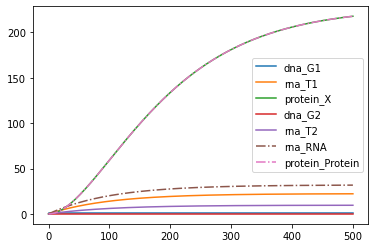

In [6]:
from vivarium_bioscrape.library.mappings import one_to_many_map, many_to_one_map

#Create Bioscrape Processes
#Model 1: is a simple transcription translation model
bsp1 = Bioscrape(parameters = {
    'sbml_file':'model1b.xml'
    })

#Model 4 adds degredation by dilution to proteins and RNAs
bsp2 = Bioscrape(parameters = {
    'sbml_file':'model4.xml'
    })

#Create the map_function using one_to_one_map
#rna_T1 + rna_T2 --> rna_RNA
#protein_X1 + protein_X2 --> protein_Protein
#the many_to_one_map takes the two processes and a dictionary {one_species:[list of many species]}
map_func_12 = many_to_one_map(bsp1, bsp2, {"rna_RNA":["rna_T1", "rna_T2"], 
                               "protein_Protein":['protein_X']})

#Create the reverse map_function
#rna_RNA --> rna_T1 + rna_T2
#protein_Protein --> protein_X1 + protein_X2
#These species are added proportionally to their concentrations, or evenly if the concentrations are
map_func_21 = one_to_many_map(bsp2, bsp1,  {"rna_RNA":["rna_T1", "rna_T2"], 
                               "protein_Protein":['protein_X']})

#create a BioscrapeConnector called composite
composite = BioscrapeConnector()

#Add models to the composite
composite.add_model(name = "txtl", bioscrape_process = bsp1)
composite.add_model(name = "dilution", bioscrape_process = bsp2)

print(composite.models)
#Add connections to the composite
composite.add_connection(source = "txtl", target = "dilution", map_function = map_func_12)
composite.add_connection(source = "dilution", target = "txtl", map_function = map_func_21)
print(composite.connections)

#Get the initial state
initial_state = composite.initial_state({})
    
#Run a simulation
sim_settings = {
        'total_time': 500,
        'initial_state': initial_state}
output = simulate_compartment_in_experiment(composite, sim_settings)

#Plot results
for s in output['txtl_species']:
    plt.plot(output['time'], output['txtl_species'][s], label = s)
for s in output['dilution_species']:
    plt.plot(output['time'], output['dilution_species'][s], "-.", label = s)
plt.legend()

'\n#create a BioscrapeConnector called composite\ncomposite = BioscrapeConnector()\n\n#Add models to the composite\ncomposite.add_model(name = "txtl", bioscrape_process = bsp1)\ncomposite.add_model(name = "dilution", bioscrape_process = bsp2)\n\nprint(composite.models)\n#Add connections to the composite\ncomposite.add_connection(source = "txtl", target = "dilution", map_function = map_func_12)\ncomposite.add_connection(source = "dilution", target = "txtl", map_function = map_func_21)\nprint(composite.connections)\n\n#Get the initial state\ninitial_state = composite.initial_state({})\n    \n#Run a simulation\nsim_settings = {\n        \'total_time\': 500,\n        \'initial_state\': initial_state}\noutput = simulate_compartment_in_experiment(composite, sim_settings)\n\n#Plot results\nfor s in output[\'txtl_species\']:\n    plt.plot(output[\'time\'], output[\'txtl_species\'][s], label = s)\nfor s in output[\'dilution_species\']:\n    plt.plot(output[\'time\'], output[\'dilution_species\'